<a href="https://colab.research.google.com/github/KrisDA-1/NU_Pandas/blob/main/W4_Imbalanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imbalanced learn

*   oversampling: oversample the minority class
*   understampling: undersample the majority class
*   combination: use a combination of oversampling and undersampling.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification


In [2]:
plt.style.use('ggplot')
np.random.seed(37)

X,y=make_classification(**{
    'n_samples':5000,
    'n_features':5,
    'n_classes':2,
    'random_state':37,
})

columns=[f'x{i}' for i in range(X.shape[1])]+['y']
df=pd.DataFrame(np.hstack([X,y.reshape(-1,1)]),columns=columns)
print(df.shape)


(5000, 6)


In [3]:
df.head()

,x0,x1,x2,x3,x4,y
0,-0.729402,0.390517,-0.603771,0.286312,-0.266412,0.0
1,0.030495,-0.970299,1.223902,-0.343972,-0.479884,0.0
2,-0.657696,-0.811643,-1.075159,0.405169,-0.022806,0.0
3,0.138540,2.012018,-1.825350,0.482964,0.845321,1.0
4,2.231350,-0.705512,-0.453736,-0.238611,1.757486,1.0


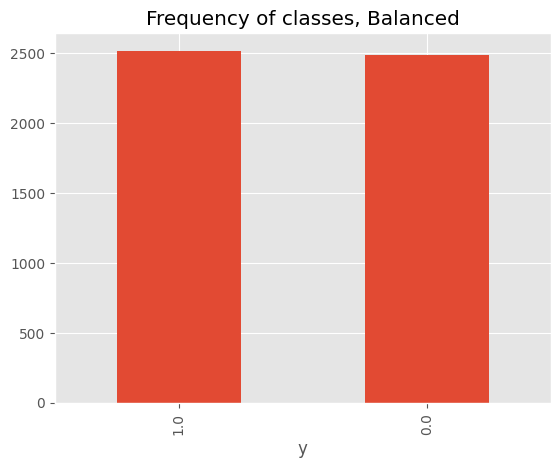

In [4]:
ax=df.y.value_counts().plot(kind='bar')
_=ax.set_title('Frequency of classes, Balanced')

##Class imbalance

*   We will then transform the data so that class 0 is the majority class and class 1 is the minority class




In [5]:
df0=df[df.y==0].copy(deep=True).reset_index(drop=True)
df1 = df[df.y == 1].sample(frac=0.01).copy(deep=True).reset_index(drop=True)

df = pd.concat([df0, df1])

In [6]:
df.shape

(2508, 6)

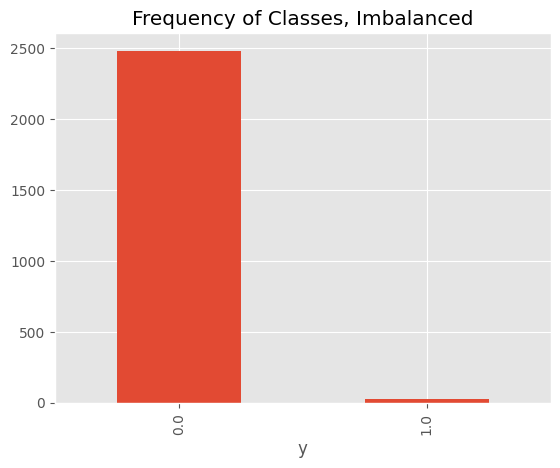

In [7]:
ax = df.y.value_counts().plot(kind='bar')
_ = ax.set_title('Frequency of Classes, Imbalanced')

##Learning with class imbalance

*   We will use a random forest classifier to learn from the imbalanced data



In [8]:
X = df[[c for c in df.columns if c != 'y']]
y = df.y

print(X.shape, y.shape)

(2508, 5) (2508,)


In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=37)

rdf = []
for fold, (tr, te) in enumerate(skf.split(X, y)):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]

    model = LogisticRegression(penalty='l2', solver='liblinear', random_state=37)
    model = RandomForestClassifier(n_jobs=-1, random_state=37)
    model.fit(X_tr, y_tr)
    y_pr = model.predict_proba(X_te)[:,1]

    auc = roc_auc_score(y_te, y_pr)
    aps = average_precision_score(y_te, y_pr)

    rdf.append({'auc': auc, 'aps': aps})

rdf = pd.DataFrame(rdf)

In [10]:
rdf[['auc', 'aps']].agg(['mean', 'std'])

,auc,aps
mean,0.972218,0.750400
std,0.080609,0.305972


##Oversampling

*   Results of applying multiple oversampling techniques with random forest classification validated by stratified, k-fold cross-validation.




In [31]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from sklearn.cluster import KMeans
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

def get_oversampler(sampler):
    if sampler == 'adasyn':
        return ADASYN(random_state=37, n_neighbors=5)
    elif sampler == 'borderlinesmote':
        return BorderlineSMOTE(random_state=37, k_neighbors=5, m_neighbors=10)
    elif sampler == 'svmsmote':
        return SVMSMOTE(random_state=37, k_neighbors=5, m_neighbors=10)
    elif sampler == 'kmeanssmote':
        kmeans = KMeans(n_clusters=2, random_state=37)
        return KMeansSMOTE(random_state=37, k_neighbors=5, kmeans_estimator=kmeans,
                           cluster_balance_threshold=0.1)
    elif sampler == 'random':
        return RandomOverSampler(random_state=37)
    else:  # 'smote' u otros
        return SMOTE(random_state=37, k_neighbors=5)

def get_results(sampler, f):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=37)

    results = []
    for fold, (tr, te) in enumerate(skf.split(X, y)):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y.iloc[tr], y.iloc[te]

        counts = sorted(Counter(y_tr).items())
        n_0, n_1 = counts[0][1], counts[1][1]

        if sampler != 'none':
            sampling_approach = f(sampler)
            X_tr, y_tr = sampling_approach.fit_resample(X_tr, y_tr)

        model = RandomForestClassifier(n_jobs=-1, random_state=37)
        model.fit(X_tr, y_tr)
        y_pr = model.predict_proba(X_te)[:, 1]

        auc = roc_auc_score(y_te, y_pr)
        aps = average_precision_score(y_te, y_pr)

        counts = sorted(Counter(y_tr).items())
        r_0, r_1 = counts[0][1], counts[1][1]

        results.append({
            'sampler': sampler,
            'auc': auc,
            'aps': aps,
            'n_maj': n_0,
            'r_maj': r_0,
            'n_min': n_1,
            'r_min': r_1
        })

    return results

In [32]:
%%time

samplers = ['none', 'random', 'smote', 'adasyn', 'borderlinesmote', 'svmsmote']
odf = pd.DataFrame(list(chain(*[get_results(s, get_oversampler) for s in samplers])))

CPU times: user 55.4 s, sys: 1.42 s, total: 56.9 s
Wall time: 39.3 s


In [33]:
odf[['sampler', 'auc', 'aps']].groupby('sampler').agg(['mean', 'std'])

auc                 aps          
                     mean       std      mean       std
sampler                                                
adasyn           0.971713  0.080083  0.748178  0.222613
borderlinesmote  0.971511  0.080007  0.734289  0.206186
none             0.972218  0.080609  0.750400  0.305972
random           0.972351  0.079962  0.778178  0.242363
smote            0.972014  0.079815  0.759844  0.204722
svmsmote         0.971881  0.080504  0.739844  0.278877

##Undersampling

*   Results of applying multiple undersampling techniques with random forest classification validated by stratified, k-fold cross-validation




In [34]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, CondensedNearestNeighbour, OneSidedSelection, NeighbourhoodCleaningRule, InstanceHardnessThreshold

def get_undersampler(sampler):
    if 'random' == sampler:
        p = {
            'random_state': 37
        }
        return RandomUnderSampler(**p)
    elif 'nearmiss1' == sampler:
        p = {
            'version': 1,
            'n_jobs': -1
        }
        return NearMiss(**p)
    elif 'nearmiss2' == sampler:
        p = {
            'version': 2,
            'n_jobs': -1
        }
        return NearMiss(**p)
    elif 'nearmiss3' == sampler:
        p = {
            'version': 3,
            'n_jobs': -1
        }
        return NearMiss(**p)
    elif 'editednn' == sampler:
        p = {
            'n_jobs': -1
        }
        return EditedNearestNeighbours(**p)
    elif 'reditednn' == sampler:
        p = {
            'n_jobs': -1
        }
        return RepeatedEditedNearestNeighbours(**p)
    elif 'condensednn' == sampler:
        p = {
            'random_state': 37,
            'n_jobs': -1
        }
        return CondensedNearestNeighbour(**p)
    elif 'onesided' == sampler:
        p = {
            'random_state': 37,
            'n_jobs': -1
        }
        return OneSidedSelection(**p)
    elif 'neighcleanrule' == sampler:
        p = {
            'n_jobs': -1
        }
        return NeighbourhoodCleaningRule(**p)
    elif 'instancehardthresh' == sampler:
        estimator = LogisticRegression(solver='lbfgs', multi_class='auto')
        p = {
            'estimator': estimator,
            'random_state': 37,
            'n_jobs': -1
        }
        return InstanceHardnessThreshold(**p)

In [35]:
%%time

samplers = ['random', 'nearmiss1', 'nearmiss2',
            'nearmiss3', 'editednn', 'reditednn', 'condensednn',
            'onesided', 'neighcleanrule']
udf = pd.DataFrame(list(chain(*[get_results(s, get_undersampler) for s in samplers])))

CPU times: user 39.3 s, sys: 2.66 s, total: 42 s
Wall time: 42.7 s


In [36]:
udf[['sampler', 'auc', 'aps']].groupby('sampler').agg(['mean', 'std'])

auc                 aps          
                    mean       std      mean       std
sampler                                               
condensednn     0.994261  0.010101  0.746438  0.278687
editednn        0.971847  0.081873  0.745956  0.281920
nearmiss1       0.991982  0.007731  0.661993  0.202126
nearmiss2       0.992929  0.009534  0.678327  0.251700
nearmiss3       0.991876  0.015964  0.727037  0.274334
neighcleanrule  0.972586  0.081067  0.794844  0.270572
onesided        0.971445  0.082091  0.714289  0.278155
random          0.996172  0.006600  0.792222  0.225959
reditednn       0.972047  0.081932  0.767622  0.258529

##Combination

*   Results of applying multiple combination techniques with random forest classification validated by stratified, k-fold cross-validation


In [37]:
from imblearn.combine import SMOTEENN, SMOTETomek

def get_combine(sampler):
    if 'smoteenn' == sampler:
        p = {
            'random_state': 37,
            'k_neighbors': 5
        }
        smote = SMOTE(**p)

        p = {
            'n_jobs': -1
        }
        enn = EditedNearestNeighbours(**p)

        p = {
            'smote': smote,
            'enn': enn,
            'n_jobs': -1,
            'random_state': 37
        }
        return SMOTEENN(**p)
    elif 'smotetomek' == sampler:
        p = {
            'random_state': 37,
            'k_neighbors': 5
        }
        smote = SMOTE(**p)

        p = {
            'smote': smote,
            'random_state': 37,
            'n_jobs': -1
        }
        return SMOTETomek(**p)

In [38]:
%%time

samplers = ['smoteenn', 'smotetomek']
cdf = pd.DataFrame(list(chain(*[get_results(s, get_combine) for s in samplers])))

CPU times: user 24.5 s, sys: 702 ms, total: 25.2 s
Wall time: 17.8 s


In [39]:
cdf[['sampler', 'auc', 'aps']].groupby('sampler').agg(['mean', 'std'])

auc                 aps          
                mean       std      mean       std
sampler                                           
smoteenn    0.971678  0.080401  0.726511  0.241162
smotetomek  0.972014  0.079815  0.759844  0.204722

##Comparisons

In [40]:
odf['type'] = odf.sampler.apply(lambda s: 'baseline' if s == 'none' else 'over')
udf['type'] = 'under'
cdf['type'] = 'combo'

rdf = pd.concat([odf, udf, cdf]).reset_index(drop=True)

In [41]:
sort = [('aps', 'mean'), ('aps', 'std'), ('auc', 'mean'), ('auc', 'std')]
rdf[['sampler', 'type', 'auc', 'aps']]\
    .groupby(['type', 'sampler'])\
    .agg(['mean', 'std'])\
    .sort_values(sort, ascending=False)

auc                 aps          
                              mean       std      mean       std
type     sampler                                                
under    neighcleanrule   0.972586  0.081067  0.794844  0.270572
         random           0.996172  0.006600  0.792222  0.225959
over     random           0.972351  0.079962  0.778178  0.242363
under    reditednn        0.972047  0.081932  0.767622  0.258529
combo    smotetomek       0.972014  0.079815  0.759844  0.204722
over     smote            0.972014  0.079815  0.759844  0.204722
baseline none             0.972218  0.080609  0.750400  0.305972
over     adasyn           0.971713  0.080083  0.748178  0.222613
under    condensednn      0.994261  0.010101  0.746438  0.278687
         editednn         0.971847  0.081873  0.745956  0.281920
over     svmsmote         0.971881  0.080504  0.739844  0.278877
         borderlinesmote  0.971511  0.080007  0.734289  0.206186
under    nearmiss3        0.991876  0.015964  0.727037  0.274334
combo    smoteenn         0.971678  0.080401  0.726511  0.241162
under    onesided         0.971445  0.082091  0.714289  0.278155
         nearmiss2        0.992929  0.009534  0.678327  0.251700
         nearmiss1        0.991982  0.007731  0.661993  0.202126

##Pipeline
If you need to use one of the samplers in a pipeline, do not use sklearn.pipeline.Pipeline, instead, use imblearn.pipeline, which is a drop-in replacement. Here’s an example of a learning pipeline with hyperparameter tuning

In [47]:
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import ADASYN

def get_model(n_splits=5):
    cv = StratifiedKFold(**{
        'n_splits': n_splits,
        'shuffle': True,
        'random_state': 37
    })

    auc_scorer = make_scorer(
        roc_auc_score,
        greater_is_better=True,
        needs_proba=True,
        multi_class='ovo')

    scoring = {
      'auc': auc_scorer
    }

    scaler = MinMaxScaler()
    sampler = ADASYN(**{
        'random_state': 37,
        # 'n_jobs': -1 # n_jobs is not a parameter for ADASYN
    })
    classifier = RandomForestClassifier(**{
        'random_state': 37,
        'n_jobs': -1,
        'verbose': 0
    })

    pipeline = Pipeline([
        ('scaler', scaler),
        ('sampler', sampler),
        ('classifier', classifier)
    ])

    param_grid = {
      'sampler__sampling_strategy': ['all', 'auto'],
      'sampler__n_neighbors': [3, 5],
      'classifier__n_estimators': [50, 100]
    }

    model = GridSearchCV(**{
        'estimator': pipeline,
        'cv': cv,
        'param_grid': param_grid,
        'verbose': 1,
        'scoring': scoring,
        'refit': 'auc',
        'error_score': np.nan,
        'n_jobs': -1
    })
    return model

In [48]:
model = get_model(n_splits=2)
model.fit(X, y)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=37, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('sampler', ADASYN(random_state=37)),
                                       ('classifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=37))]),
             n_jobs=-1,
             param_grid={'classifier__n_estimators': [50, 100],
                         'sampler__n_neighbors': [3, 5],
                         'sampler__sampling_strategy': ['all', 'auto']},
             refit='auc',
             scoring={'auc': make_scorer(roc_auc_score, response_method='predict', needs_proba=True, multi_class=ovo)},
             verbose=1)

In [49]:
model.best_params_

{'classifier__n_estimators': 50,
 'sampler__n_neighbors': 3,
 'sampler__sampling_strategy': 'all'}

In [50]:
y_pr = model.predict_proba(X)[:,1]

auc = roc_auc_score(y, y_pr)
aps = average_precision_score(y, y_pr)

print(f'auc = {auc:.5f}, aps = {aps:.5f}')

auc = 1.00000, aps = 1.00000
